# Particle MCMC model for COVID-19 in Mexico

This notebook contains all of the Python code needed to use Particle Marginal Markov Chain Monte Carlo to explore the parameter space of our diffusion driven model and estimate the trajectories of the hidden states

In [7390]:
# Import all necesary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import gammaln
import math

In [7391]:
data = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/covid_df.feather')
weekly_covid_df = data.groupby([pd.Grouper(key='date', freq='W-SUN')]).agg({
    'confirmed_cases': 'sum',
    'confirmed_deaths': 'sum'
}).reset_index()
weekly_covid_df.head()

,date,confirmed_cases,confirmed_deaths
0,2020-02-23,4.0,0.0
1,2020-03-01,23.0,0.0
2,2020-03-08,131.0,0.0
3,2020-03-15,624.0,0.0
4,2020-03-22,1152.0,6.0


In [7847]:
pop = pd.read_feather('/Users/ro/Desktop/Undergrad_AM_Thesis/Data/INEGI_2020_State_Population.feather')
N = pop['population'].sum()
print('Total Population: ', N)
print('0.01% of Population: ', np.round(0.001*N).astype(int))


Total Population:  126014024
0.01% of Population:  126014


Below we create two functions to draw from our prior distributions for initial value conditions and model parameters

In [7649]:
# Initial Value Conditions Prior
def set_IVC(N, rho, nu, num_particles):
    R = np.zeros(num_particles)
    D = np.zeros(num_particles)
    E = stats.uniform(0, np.round(0.0001 * N).astype(int)).rvs(num_particles)   #stats.uniform(0, 100).rvs(num_particles)
    U = stats.uniform(0, np.round(E).astype(int)).rvs(num_particles)           #stats.uniform(0,5).rvs(num_particles)
    O = stats.uniform(0, np.round(U).astype(int)).rvs(num_particles) 
    E = E - U - O    
    S = N - E - U 
    
    beta = stats.uniform(0.5,2).rvs(num_particles)
    mu = stats.uniform(0,1).rvs(num_particles)
    
    return np.vstack([S, E, U, O, R, D, beta, mu])

def set_param_priors():
    alpha = stats.beta(2.3, 96.5).rvs()
    rho = stats.beta(7.2, 0.8).rvs()
    nu = stats.beta(6.9, 14.1).rvs()
    gamma = stats.beta(2.36, 9.44).rvs()
    sigma_b = stats.invgamma(a=3.8, scale=0.6).rvs()
    sigma_m = stats.invgamma(a=3.8, scale=0.6).rvs()
    psi_o = stats.gamma(50,scale=100).rvs()
    psi_d = stats.gamma(5,scale=10).rvs()
    
    return [alpha, rho, nu, gamma, sigma_b, sigma_m, psi_o, psi_d]
    

We begin by defining the SEUORDS model and understanding if the model will be able to produce results similar to those seen during the COVID-19 pandemic in Mexico

In [7650]:
def BM_SEUORDS(X_in, params, num_particles, m):
    num_steps = m + 1  # Initial step + m observations + final step
    h = 1 / num_steps  # Adjust step size

    # Initialize arrays to store results
    X = np.zeros([X_in.shape[0], num_particles, num_steps + 1])
    Z1 = np.zeros([num_particles, num_steps + 1])
    Z2 = np.zeros([num_particles, num_steps + 1])
    
    new_undetected = np.zeros([num_particles])
    new_observed = np.zeros([num_particles])
    new_deaths = np.zeros([num_particles])

    # Set initial conditions
    alpha, rho, nu, gamma, sigma_b, sigma_m, _, _ = params
    X[:, :, 0] = X_in
    Z1[:, 0] = np.log(X_in[6, :])  # Logit for beta(0)
    Z2[:, 0] = np.log(X_in[7, :])  # Logit for mu(0)

    # Simulate the SIR model with stochastic beta using Euler-Maruyama method
    for t in range(1, num_steps + 1):
        # Sample Brownian increment
        dB1 = stats.norm(0, 1).rvs(num_particles)
        dB2 = stats.norm(0, 1).rvs(num_particles)
        
        # Update Z using Euler-Maruyama method
        Z1[:, t] = Z1[:, t - 1] + sigma_b * dB1 * np.sqrt(h)
        Z2[:, t] = Z2[:, t - 1] + sigma_m * dB2 * np.sqrt(h)
        
        # Update time-varying parameter values
        X[6, :, t] = np.exp(Z1[:, t]) # beta(t)
        X[7, :, t] = np.exp(Z2[:, t]) # mu(t)
        
        # Update SEUORDS model
        X[0, :, t] = X[0, :, t - 1] + (-X[6, :, t] * (X[2, :, t - 1] + X[3, :, t - 1]) * X[0, :, t - 1] / N + alpha * X[4, :, t - 1]) * h     # S-Susceptibles
        X[1, :, t] = X[1, :, t - 1] + (X[6, :, t] * (X[2, :, t - 1] + X[3, :, t - 1]) * X[0, :, t - 1] / N - nu * X[1, :, t - 1]) * h         # E-Exposed
        X[2, :, t] = X[2, :, t - 1] + (rho * nu * X[1, :, t - 1] - gamma * X[2, :, t - 1]) * h                                                # U-Unobserved
        X[3, :, t] = X[3, :, t - 1] + ((1 - rho) * nu * X[1, :, t - 1] - gamma * X[3, :, t - 1] - X[7, :, t] * X[3, :, t - 1]) * h            # O-Observed
        X[4, :, t] = X[4, :, t - 1] + (gamma * (X[2, :, t - 1] + X[3, :, t - 1]) - alpha * X[4, :, t - 1]) * h                                # R-Recovered
        X[5, :, t] = X[5, :, t - 1] + (X[7, :, t] * X[3, :, t - 1]) * h                                                                       # D-Death
        
        new_undetected += (rho * nu * X[1, :, t - 1]) * h
        new_observed += ((1 - rho) * nu * X[1, :, t - 1]) * h
        new_deaths += (X[7, :, t] * X[3, :, t - 1]) * h   
    
    return X, new_observed, new_deaths, new_undetected

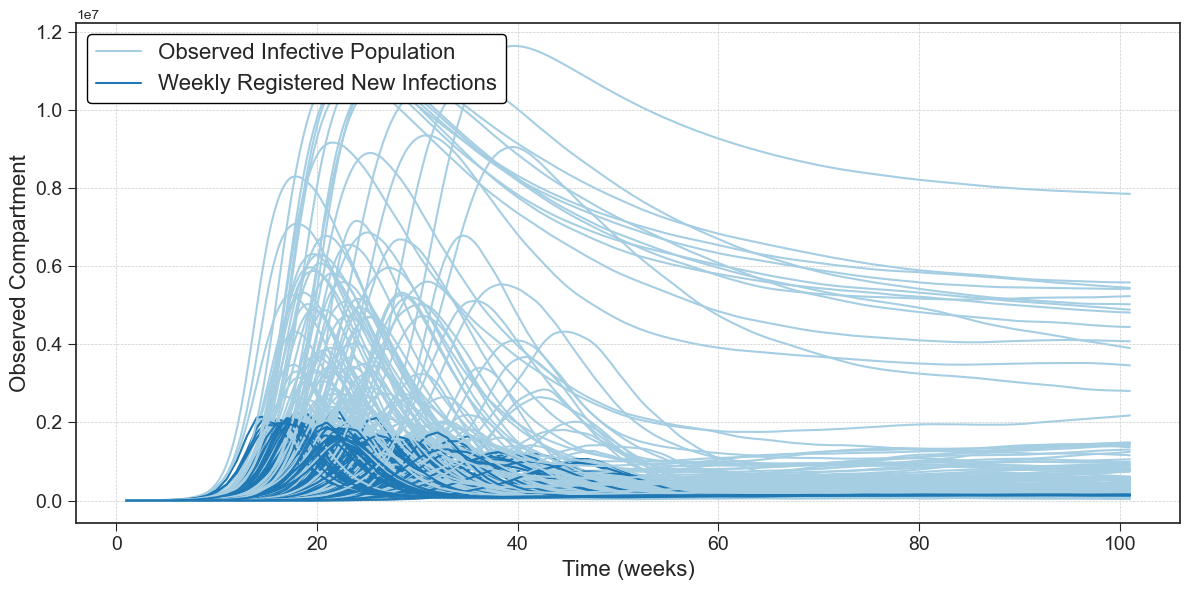

In [7659]:
# Define the number of periods and steps per period
T = 100 # Number of periods 
m = 5  # Number of observations per period (intermediate steps)
num_steps = m + 1  # Number of time steps per period including the initial step
total_steps = T * num_steps  # Total number of time steps across all periods
num_particles = 150  # Number of particles

# Set initial conditions
params = set_param_priors()
initial_states = set_IVC(N, params[1], params[2], num_particles)

# Initialize the arrays to store results
states = np.zeros([initial_states.shape[0], num_particles, total_steps + 1])  # Includes the initial step
states[:, :, 0] = initial_states  
aggregates = np.zeros([3, num_particles, T + 1])  
start_idx = 0  

# Run the model over T periods with weekly aggregation
for t in range(1, T + 1):
    end_idx = start_idx + m + 1 
    weekly_results, new_observed, new_deaths, new_undetected = BM_SEUORDS(states[:, :, start_idx], params, num_particles, m)
    # Store the generated states and aggregate counts for this period
    states[:, :, start_idx + 1:end_idx+1] = weekly_results[:, :, 1:]
    aggregates[:, :, t] = np.stack((new_observed, new_deaths, new_undetected), axis=0)
    
    # Update the start index for the next period
    start_idx = end_idx


# Plot the simulation for each particle
time = np.linspace(1, T+1, total_steps+1 )

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(time, states[3, 0, :], color=colors[0], label='Observed Infective Population')
plt.plot(np.arange(1,T+2), aggregates[0, 0, :], color=colors[1], label='Weekly Registered New Infections')
    
for p in range(1,num_particles):
    plt.plot(time, states[3, p, :], color=colors[0])
    plt.plot(np.arange(1,T+2), aggregates[0, p, :], color=colors[1])

plt.legend(
    loc='upper left',
    fontsize=16, 
    title='', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')
plt.xlabel('Time (weeks)', fontsize=16)
plt.ylabel('Observed Compartment', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

We now define our negative binomial function to run our bootstrap particle filter

In [7660]:
# Create NB log-likelihood function
def NB_log_likelihood(y, mu, psi):
    # Add a small positive constant to avoid numerical instability
    mu = np.maximum(mu, 1e-10)
    psi = np.maximum(psi, 1e-10)
    aux = np.maximum(mu + psi, 1e-10)
    
    return gammaln(y + psi) - gammaln(y+1) - gammaln(psi) + y * (np.log(mu) - np.log(aux)) + psi * (np.log(psi) - np.log(aux))

Following the steps of Dahlin, J. and Schön, T. B.$^1$ we work with the shifted log weights to avoid problems with numerical precision where we define
$$
v^{(i)}_t = \log(w^{(i)}_t) - v_{max}
$$
with $v_{max} = \max_{i} \log(w^{(i)}_t)$ and $w^{(i)}_t = e^{v_{max}} e^{v^{(i)}_t}$. 

With this in mind, the normalized weights can be calculated using 
$$ 
\bar{w}^{(i)}_t = \frac{w^{(i)}_t}{\sum_i w^{(i)}_t} = \frac{e^{v_{max}} e^{v^{(i)}_t}}{\sum_i e^{v_{max}} e^{v^{(i)}_t}} = \frac{e^{v^{(i)}_t}}{\sum_i e^{v^{(i)}_t}} = \tilde{v}^{(i)}_t.
$$

Additionally, instead of calculating the marginal likelihood
$$
\hat{p}(y_{1:t}) = \hat{p}(y_{1:t-1}) \hat{p}(y_t | y_{1:t-1}) = \hat{p}(y_{1:t-1}) \left( \frac{1}{N} \sum_i w^{(i)}_t \right)
$$
we can approximate the marginal log-likelihood using $w^{(i)}_t = e^{v_{max}} e^{v^{(i)}_t}$ with
\begin{align*}
\log (\hat{p}(y_{1:t})) & = \log(\hat{p}(y_{1:t-1})) + \log\left( \sum_i w^{(i)}_t \right) - \log(N) \\
                        & = \log(\hat{p}(y_{1:t-1})) + \log\left( \sum_i e^{v_{max}} e^{v^{(i)}_t}\right) - \log(N) \\
                        & = \log(\hat{p}(y_{1:t-1})) + \log(v_{max}) + \log\left( \sum_i e^{v^{(i)}_t} \right) - \log(N)
\end{align*}

$1$: Dahlin, J., & Schön, T. B. (2019). *Getting started with particle Metropolis-Hastings for inference in nonlinear dynamical models*. Journal of Statistical Software, 88, 1–41.


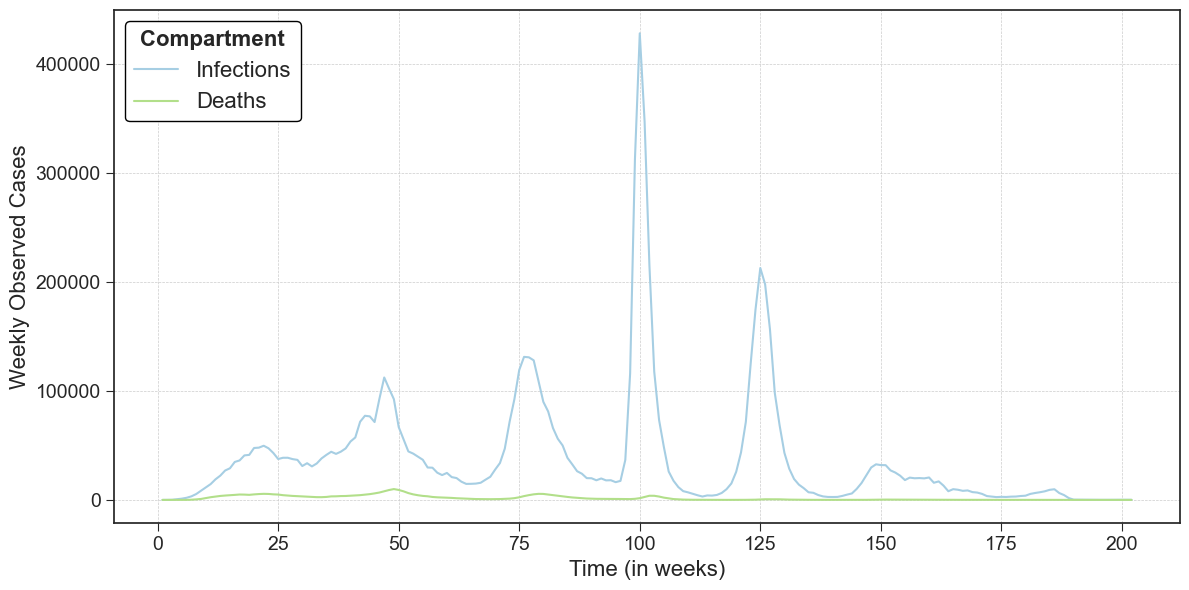

In [7661]:
# Define subset of data to run the algorithm 
weeks = 202

YO = weekly_covid_df['confirmed_cases'].values[:weeks]
YD = weekly_covid_df['confirmed_deaths'].values[:weeks]

time = np.linspace(1, weeks, weeks)

plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(time, YO, color=colors[0], label='Infections')
plt.plot(time, YD, color=colors[2], label='Deaths')

plt.legend(
    loc='upper left',
    fontsize=16, 
    title='Compartment', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Time (in weeks)', fontsize=16)
plt.ylabel('Weekly Observed Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

In [7837]:
T =  weeks - 1
m = 10
num_steps = m + 1
total_steps = T * num_steps 
num_particles = 250 

params = set_param_priors()
initial_conditions = set_IVC(N, params[1], params[2], num_particles)

# Initialize PF variables
state_estimates = np.zeros([3, T+1])
particles = np.zeros([initial_conditions.shape[0], num_particles, total_steps + 1]) 
resampled_partices = np.zeros([initial_conditions.shape[0], num_particles, total_steps + 1]) 
weekly_aggregates = np.zeros([3, num_particles, T+1])
weights = np.zeros([num_particles, T+1])
norm_weights = np.zeros([num_particles, T+1])
ancestry_matrix = np.zeros([num_particles, T+1])
ESS = np.zeros(T+1)
loglikelihood = 0

# Define values at time t=0
particles[:, :, 0] = initial_conditions
original_particles = particles.copy()
weekly_aggregates[0,:,0] = particles[3, :, 0]
weekly_aggregates[1,:,0] = particles[5, :, 0]
weekly_aggregates[2,:,0] = particles[2, :, 0]

incremental_weights = NB_log_likelihood(YO[0], weekly_aggregates[0,:,0], params[6]) + NB_log_likelihood(YD[0], weekly_aggregates[1,:,0], params[7]) 
max_weights = np.max(incremental_weights)
weights[:,0] = np.exp(incremental_weights - max_weights)
sum_weights = weights[:,0].sum()
norm_weights[:,0] = weights[:,0] / sum_weights
    
ESS[0] = 1 / (np.sum(norm_weights[:,0]**2))
loglikelihood += max_weights + np.log(np.sum(weights[:,0])) - np.log(num_particles)
state_estimates[:,0] = np.sum(weekly_aggregates[:,:,0]*norm_weights[:,0], axis=1)

if ESS[0] <= 0.5*num_particles:
    # Systematic resampling at time t=0
    r = stats.uniform(0,1).rvs()
    positions =  (np.arange(num_particles) + r )/num_particles
    resample_indices = np.searchsorted(np.cumsum(norm_weights[:,0]), positions)
        
    ancestry_matrix[:,0] = resample_indices
    particles[:, :, 0] = particles[:, resample_indices.astype(int), 0]
    weekly_aggregates[:, :, 0] = weekly_aggregates[:, resample_indices.astype(int), 0]
else:
    ancestry_matrix[:,0] = np.arange(num_particles)
    

start_idx = 0
for t in range(1,T+1):
    # Propagate particles to next week
    weekly_results, new_observed, new_deaths, new_undetected = BM_SEUORDS(particles[:, :, start_idx], params, num_particles, m)
    weekly_aggregates[:,:,t] = np.stack((new_observed, new_deaths, new_undetected), axis=0)
    
    # Store updated particle values
    end_idx = start_idx + num_steps    
    particles[:, :, start_idx+1:end_idx+1] = weekly_results[:, :, 1:] 
    original_particles[:, :, start_idx+1:end_idx+1] = weekly_results[:, :, 1:] 
    
    # Update particle weights and resample
    incremental_weights = NB_log_likelihood(YO[t], weekly_aggregates[0,:,t], params[6]) + NB_log_likelihood(YD[t], weekly_aggregates[1,:,t], params[7]) 
    max_weights = np.max(incremental_weights)
    weights[:,t] = np.exp(incremental_weights - max_weights)
    sum_weights = weights[:,t].sum()
    norm_weights[:,t] = weights[:,t] / sum_weights
    
    ESS[t] = 1 / (np.sum(norm_weights[:,t]**2))
    loglikelihood += max_weights + np.log(np.sum(weights[:,t])) - np.log(num_particles)
    if np.isnan(loglikelihood):
        break
    state_estimates[:,t] = np.sum(weekly_aggregates[:,:,t]*norm_weights[:,t], axis=1)
    
    if ESS[t] <= 0.5*num_particles:
        # Systematic resampling
        r = stats.uniform(0,1).rvs()
        positions =  (np.arange(num_particles) + r )/num_particles
        resample_indices = np.searchsorted(np.cumsum(norm_weights[:,t]), positions)
        
        ancestry_matrix[:,t] = resample_indices
        particles[:, :, :end_idx+1] = particles[:, resample_indices.astype(int), :end_idx +1]
        weekly_aggregates[:, :, :t] = weekly_aggregates[:, resample_indices.astype(int), :t]
    else:
        ancestry_matrix[:,t] = np.arange(num_particles)
    
    start_idx = end_idx
    
print(loglikelihood)

-507700.8333602542


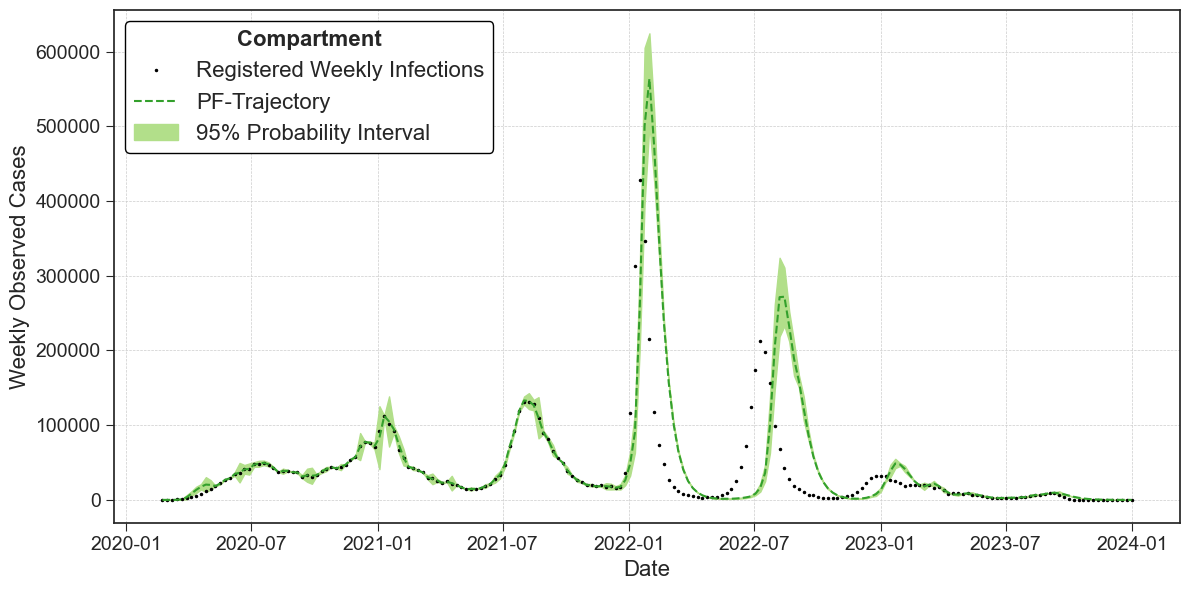

In [7838]:
error = np.sqrt(((norm_weights**2)*((weekly_aggregates - state_estimates[:, np.newaxis, :])**2)).sum(axis=1))
CI = 1.96 * error
upper = state_estimates + CI
lower= state_estimates - CI

time = np.linspace(1,T+1,T+1)

plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(weekly_covid_df['date'], YO, marker='o', linewidth=0, markersize=1.5, color='black', label='Registered Weekly Infections')
plt.plot(weekly_covid_df['date'], state_estimates[0,:], color=colors[3], label='PF-Trajectory', linestyle='--')
plt.fill_between(weekly_covid_df['date'], lower[0,:], upper[0,:], color=colors[2], label='95% Probability Interval')

plt.legend(
    loc='upper left',
    fontsize=16, 
    title='Compartment', 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Date', fontsize=16)
plt.ylabel('Weekly Observed Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

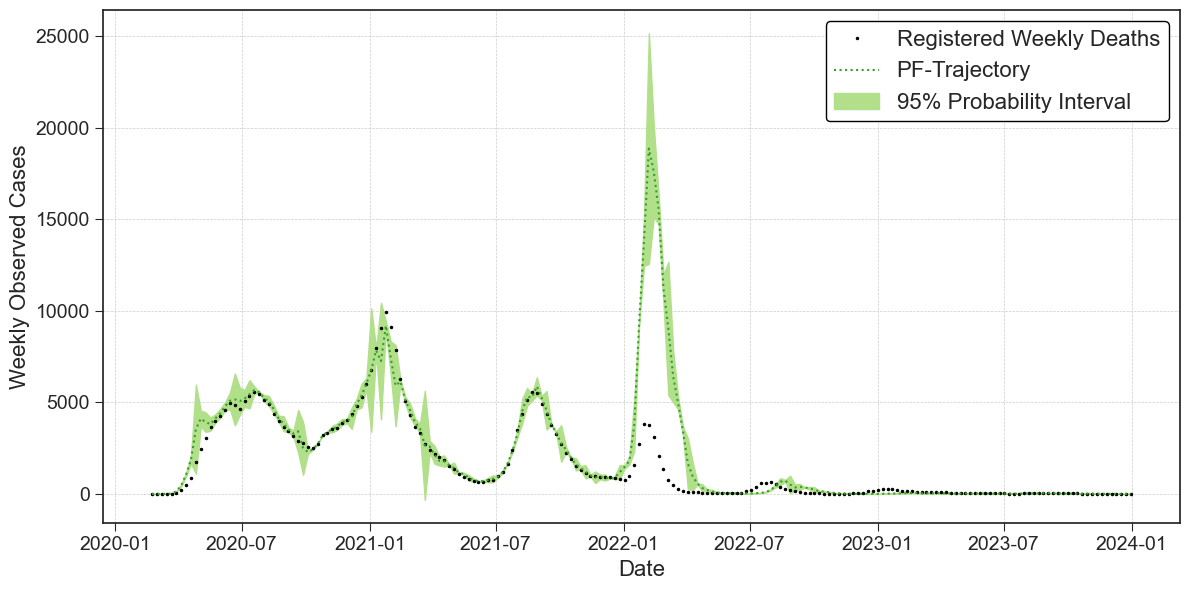

In [7840]:
plt.figure(figsize=(12,6))
plt.style.use('seaborn-v0_8-ticks')
colors = sns.color_palette('Paired')

plt.plot(weekly_covid_df['date'], YD, marker='o', linewidth=0, markersize=1.5, color='black', label='Registered Weekly Deaths')
plt.plot(weekly_covid_df['date'], state_estimates[1,:], color=colors[3], label='PF-Trajectory', linestyle=':')
plt.fill_between(weekly_covid_df['date'], lower[1,:], upper[1,:], color=colors[2], label='95% Probability Interval')

plt.legend(
    loc='upper right',
    fontsize=16, 
    title_fontproperties={'weight': 'bold', 'size': 16},
    frameon=True,                  
    fancybox=True,                 
    framealpha=1,                   
    edgecolor='black',              
    facecolor='white')

plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.xlabel('Date', fontsize=16)
plt.ylabel('Weekly Observed Cases', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(visible=True, linestyle='--', linewidth=0.5)  
plt.tight_layout()
plt.show()

In [7841]:
def particle_filter(YO, YD, N, params, num_particles, weeks, m, set_IVC, NB_log_likelihood, BM_SEUORDS):
    # Initialize parameters
    T = weeks - 1
    num_steps = m + 1
    total_steps = T * num_steps
    
    # Set initial conditions
    initial_conditions = set_IVC(N, params[1], params[2], num_particles)
    
    # Initialize PF variables
    state_estimates = np.zeros([3, T + 1])
    particles = np.zeros([initial_conditions.shape[0], num_particles, total_steps + 1])
    original_particles = particles.copy()
    resampled_particles = np.zeros([initial_conditions.shape[0], num_particles, total_steps + 1])
    weekly_aggregates = np.zeros([3, num_particles, T + 1])
    weights = np.zeros([num_particles, T + 1])
    norm_weights = np.zeros([num_particles, T + 1])
    ancestry_matrix = np.zeros([num_particles, T + 1])
    ESS = np.zeros(T + 1)
    loglikelihood = 0

    # Initialize variables at time t=0
    particles[:, :, 0] = initial_conditions
    weekly_aggregates[0, :, 0] = particles[3, :, 0]
    weekly_aggregates[1, :, 0] = particles[5, :, 0]
    weekly_aggregates[2, :, 0] = particles[2, :, 0]
    
    # Calculate initial weights and log-likelihood
    incremental_weights = (NB_log_likelihood(YO[0], weekly_aggregates[0, :, 0], params[6]) + 
                           NB_log_likelihood(YD[0], weekly_aggregates[1, :, 0], params[7]))
    max_weights = np.max(incremental_weights)
    weights[:, 0] = np.exp(incremental_weights - max_weights)
    sum_weights = weights[:, 0].sum()
    norm_weights[:, 0] = weights[:, 0] / sum_weights
    
    ESS[0] = 1 / (np.sum(norm_weights[:, 0] ** 2))
    loglikelihood += max_weights + np.log(sum_weights) - np.log(num_particles)
    state_estimates[:, 0] = np.sum(weekly_aggregates[:, :, 0] * norm_weights[:, 0], axis=1)
    
    # Resampling at time t=0 if necessary
    if ESS[0] <= 0.5 * num_particles:
        r = stats.uniform(0, 1).rvs()
        positions = (np.arange(num_particles) + r) / num_particles
        resample_indices = np.searchsorted(np.cumsum(norm_weights[:, 0]), positions)
        ancestry_matrix[:, 0] = resample_indices
        particles[:, :, 0] = particles[:, resample_indices.astype(int), 0]
        weekly_aggregates[:, :, 0] = weekly_aggregates[:, resample_indices.astype(int), 0]
    else:
        ancestry_matrix[:, 0] = np.arange(num_particles)
    
    start_idx = 0
    
    # Main loop for time t = 1 to T
    for t in range(1, T + 1):
        # Propagate particles to the next week
        weekly_results, new_observed, new_deaths, new_undetected = BM_SEUORDS(particles[:, :, start_idx], params, num_particles, m)
        weekly_aggregates[:, :, t] = np.stack((new_observed, new_deaths, new_undetected), axis=0)
        
        # Store updated particle values
        end_idx = start_idx + num_steps
        particles[:, :, start_idx + 1:end_idx + 1] = weekly_results[:, :, 1:]
        original_particles[:, :, start_idx + 1:end_idx + 1] = weekly_results[:, :, 1:]
        
        # Update particle weights and normalize
        incremental_weights = (NB_log_likelihood(YO[t], weekly_aggregates[0, :, t], params[6]) + 
                               NB_log_likelihood(YD[t], weekly_aggregates[1, :, t], params[7]))
        max_weights = np.max(incremental_weights)
        weights[:, t] = np.exp(incremental_weights - max_weights)
        sum_weights = weights[:, t].sum()
        norm_weights[:, t] = weights[:, t] / sum_weights
        
        ESS[t] = 1 / (np.sum(norm_weights[:, t] ** 2))
        loglikelihood += max_weights + np.log(sum_weights) - np.log(num_particles)
        
        # Break the loop if log-likelihood becomes NaN
        if np.isnan(loglikelihood):
            print(f"Log-likelihood is NaN at t={t}. Breaking out of the loop.")
            break
        
        # Calculate state estimates
        state_estimates[:, t] = np.sum(weekly_aggregates[:, :, t] * norm_weights[:, t], axis=1)
        
        # Resample if necessary
        if ESS[t] <= 0.5 * num_particles:
            r = stats.uniform(0, 1).rvs()
            positions = (np.arange(num_particles) + r) / num_particles
            resample_indices = np.searchsorted(np.cumsum(norm_weights[:, t]), positions)
            ancestry_matrix[:, t] = resample_indices
            particles[:, :, :end_idx + 1] = particles[:, resample_indices.astype(int), :end_idx + 1]
            weekly_aggregates[:, :, :t + 1] = weekly_aggregates[:, resample_indices.astype(int), :t + 1]
        else:
            ancestry_matrix[:, t] = np.arange(num_particles)
        
        start_idx = end_idx
    
    return state_estimates, particles, weights, norm_weights, ESS, loglikelihood, ancestry_matrix